<a href="https://colab.research.google.com/github/Laimo64/Laimo64/blob/main/AI_surgery_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1y8OFnIFYC_b_WIexKSog732_L78Pegxa/view?usp=drive_link
!unzip -q brain_small.zip

Downloading...
From (original): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa
From (redirected): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa&confirm=t&uuid=79c99e38-e261-4871-b9a8-e30cb3a1bcdd
To: /content/brain_small.zip
100% 119M/119M [00:01<00:00, 63.7MB/s]


In [ ]:
pip install monai

Data Preprocess

In [ ]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from scipy.ndimage import zoom

class MRCTDataset(Dataset):
    def __init__(self, data_dir, target_size=(96, 96, 96)):  ###### target_size=(96, 96, 96)改128試試
        """
        初始化數據集
        Args:
            data_dir (str): MRI 和 CT 數據的根目錄。
            target_size (tuple): 將 MRI 和 CT 影像調整為的固定尺寸。
        """
        self.data_dir = data_dir
        self.target_size = target_size
        self.samples = [
            os.path.join(root)
            for root, _, files in os.walk(data_dir)
            if "mr.nii.gz" in files and "ct.nii.gz" in files
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        根據索引返回一組 MR 和 CT 影像。
        Args:
            idx (int): 數據的索引。
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: MR 和 CT 的張量形式。
        """
        sample_path = self.samples[idx]

        # 加載 MRI 和 CT 影像
        mr = nib.load(os.path.join(sample_path, "mr.nii.gz")).get_fdata()
        ct = nib.load(os.path.join(sample_path, "ct.nii.gz")).get_fdata()

        # Z-score 標準化
        mr = self._normalize(mr)
        ct = self._normalize(ct)

        # 調整或填充影像大小
        mr = self._resize_or_pad(mr, self.target_size)
        ct = self._resize_or_pad(ct, self.target_size)

        # 轉換為 PyTorch 張量並增加通道維度
        mr = torch.tensor(mr, dtype=torch.float32).unsqueeze(0)  # (1, D, H, W)
        ct = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)  # (1, D, H, W)

        return mr, ct

    def _normalize(self, image):
        """
        Z-score 標準化影像數據。
        Args:
            image (np.ndarray): 輸入影像。
        Returns:
            np.ndarray: 標準化的影像。
        """
        if np.std(image) != 0:
            return (image - np.mean(image)) / np.std(image)
        else:
            return image

    def _resize_or_pad(self, image, desired_shape):
        """
        調整影像大小或填充至固定大小。
        Args:
            image (np.ndarray): 輸入影像。
            desired_shape (tuple): 目標大小。
        Returns:
            np.ndarray: 調整或填充後的影像。
        """
        current_shape = image.shape
        scale = [d / c for d, c in zip(desired_shape, current_shape)]
        resized_image = zoom(image, scale, order=1)  # 調整大小

        # 填充影像至目標大小
        padded_image = np.zeros(desired_shape, dtype=resized_image.dtype)
        pad_slices = tuple(slice(0, min(dim, resized_image.shape[i])) for i, dim in enumerate(desired_shape))
        padded_image[pad_slices] = resized_image[:desired_shape[0], :desired_shape[1], :desired_shape[2]]

        return padded_image


In [ ]:
from monai.transforms import LoadImage, Spacing, Resize, ScaleIntensity
import torch.nn.functional as F

# 1. 加載數據
loader = LoadImage(ensure_channel_first=True)
image = loader("/content/small/1BA001/ct.nii.gz")

def preprocess_image(image):
  # 2. 重採樣到統一的體素大小
  resample_transform = Spacing(pixdim=(1.0, 1.0, 1.0))
  resampled_image = resample_transform(image)

  # 3. 調整大小到固定形狀
  resize_transform = Resize(spatial_size=(128, 128, 128))
  resized_image = resize_transform(resampled_image)

  # 4. 歸一化
  normalize_transform = ScaleIntensity()
  normalized_image = normalize_transform(resized_image)


  print(f"Final processed shape: {normalized_image.shape}")

  image = normalized_image.unsqueeze(1)  # 在第 1 維新增通道維度
  print(image.shape)  # {batch size, channel, depth, height, width}
  return image



MESP(Structure)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Swin Transformer Block (簡化版，適用於3D)
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_size):
        super(SwinTransformerBlock, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, dim)
        self.window_size = input_size // 4  # 分割窗口，根據3D的尺寸調整

    def forward(self, x):
        b, c, d, h, w = x.shape  # 3D 輸入
        x = x.view(b, -1, c)  # 展平為序列
        x = self.norm(x)
        x = self.fc(x)
        return x.view(b, c, d, h, w)  # 還原為 3D

# MSEP 網路
class MSEP(nn.Module):
    def __init__(self):
        super(MSEP, self).__init__()
        # Encoder 部分
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1),  # 使用3D卷積
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),  # 使用3D卷積
            nn.ReLU()
        )
        # Skip 連接部分 + RDSformer
        self.skip = SwinTransformerBlock(128, input_size=160)
        # Decoder 部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1),  # 使用3D反卷積
            nn.ReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=1, padding=1)  # 使用3D反卷積
        )

    def forward(self, x):
        enc = self.encoder(x)
        skip = self.skip(enc)  # 加入 skip connection
        dec = self.decoder(skip)
        return dec

# Initialize model
model = MSEP()

# Test the model with dummy data (e.g., [Batch Size, Channel, Depth, Height, Width])
dummy_input = torch.randn(1, 1, 128, 128, 128)  # 假設數據大小是 [1, 1, 128, 128, 128]
output = model(dummy_input)

print("Output shape:", output.shape)  # 應該返回符合預期的 3D 輸出


Output shape: torch.Size([1, 1, 128, 128, 128])


Training

MR shape: torch.Size([2, 1, 96, 96, 96]), CT shape: torch.Size([2, 1, 96, 96, 96])


Epoch 1/50: 100%|██████████| 3/3 [00:07<00:00,  2.35s/it, loss=0.464]


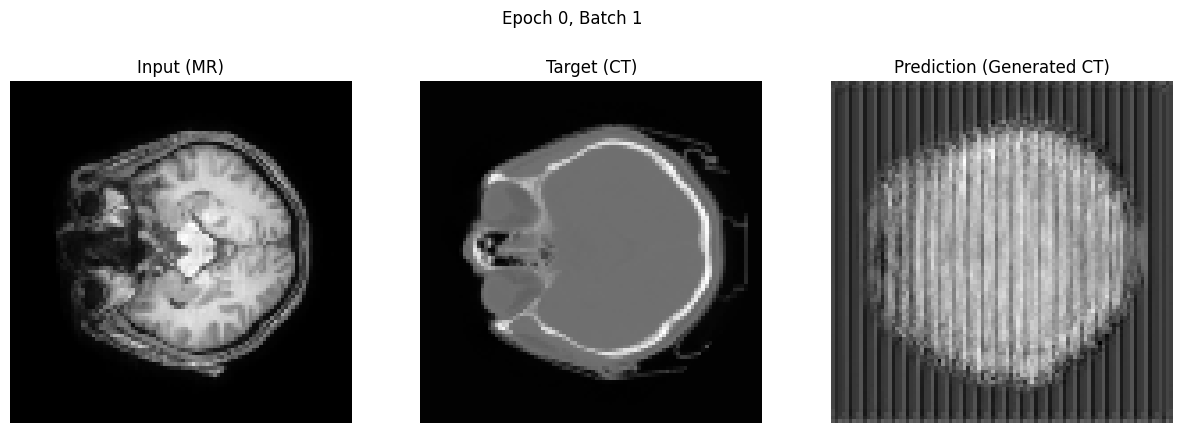

Epoch 1/50, Avg Train Loss: 0.4925297200679779


Epoch 2/50: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it, loss=0.455]


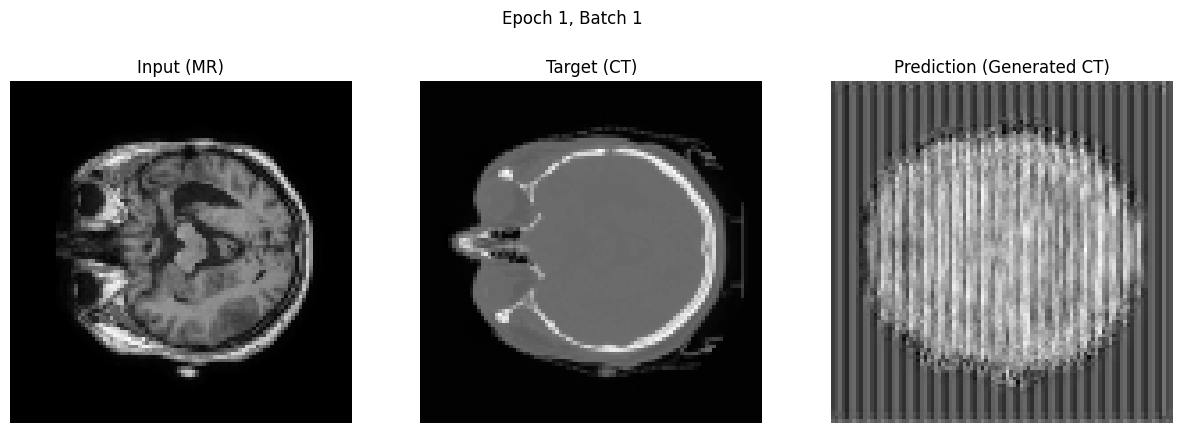

Epoch 2/50, Avg Train Loss: 0.44961660106976825


Epoch 3/50: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it, loss=0.389]


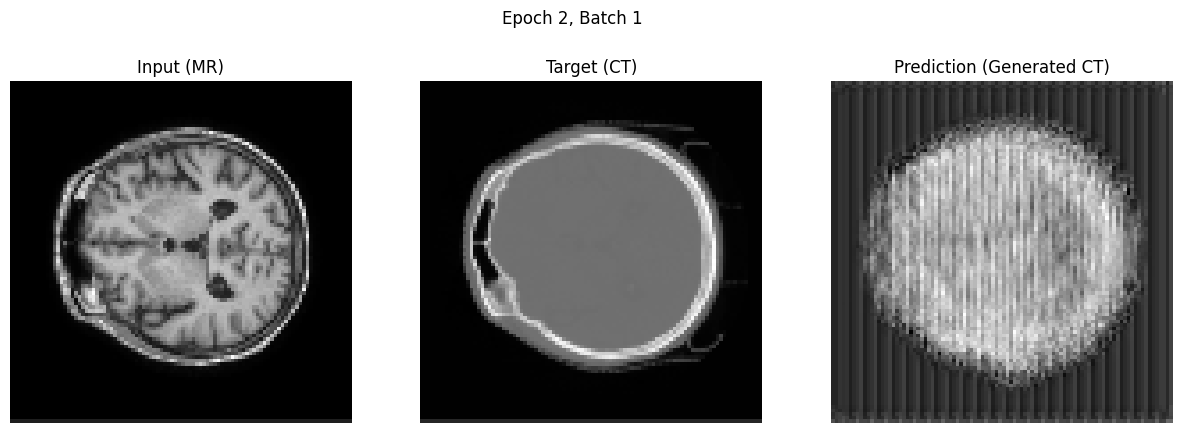

Epoch 3/50, Avg Train Loss: 0.3988310396671295


Epoch 4/50: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it, loss=0.399]


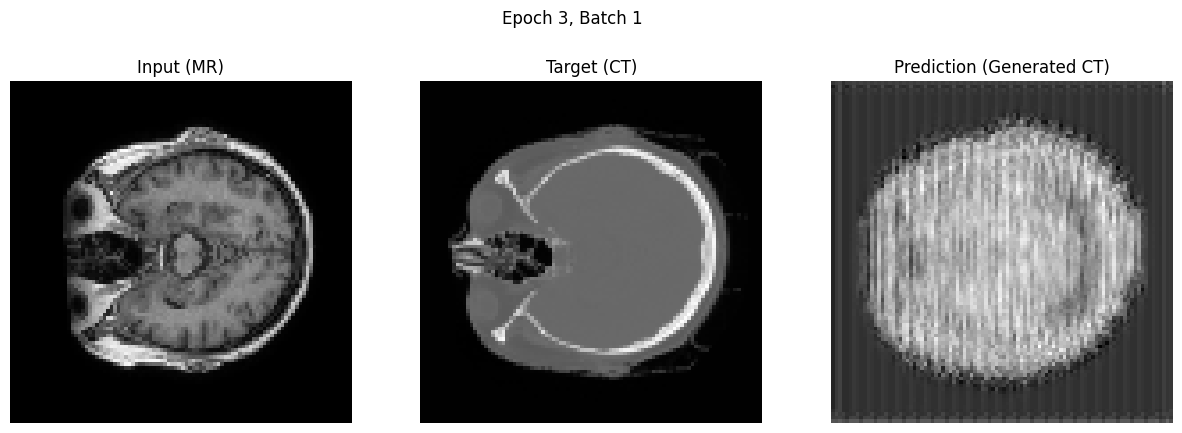

Epoch 4/50, Avg Train Loss: 0.38548444708188373


Epoch 5/50: 100%|██████████| 3/3 [00:08<00:00,  2.82s/it, loss=0.347]


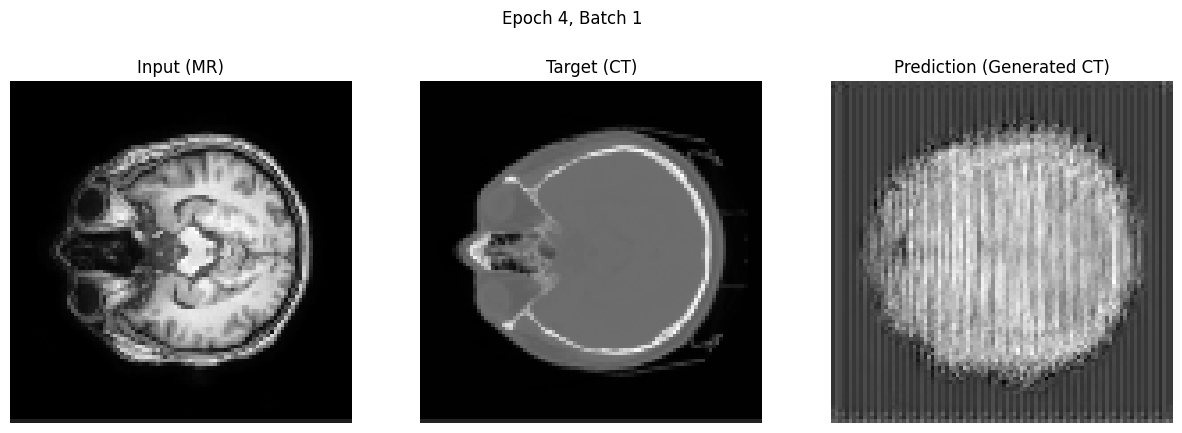

Epoch 5/50, Avg Train Loss: 0.3590041895707448


Epoch 6/50: 100%|██████████| 3/3 [00:07<00:00,  2.35s/it, loss=0.329]


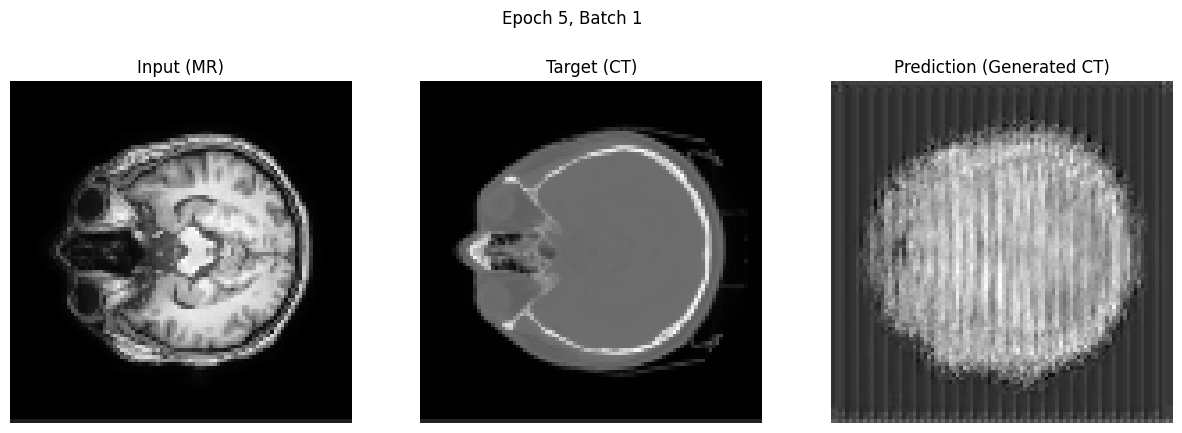

Epoch 6/50, Avg Train Loss: 0.3389912048975627


Epoch 7/50: 100%|██████████| 3/3 [00:07<00:00,  2.47s/it, loss=0.352]


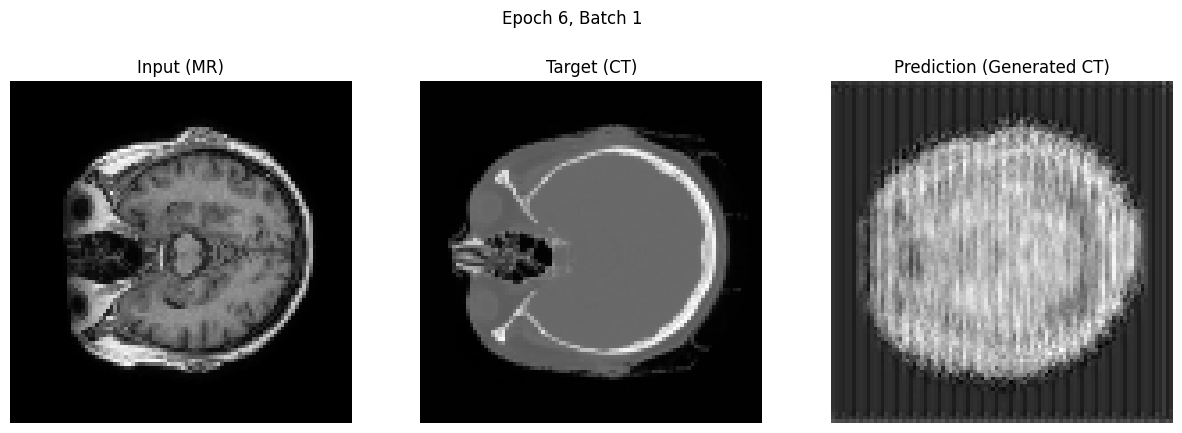

Epoch 7/50, Avg Train Loss: 0.3321065406004588


Epoch 8/50: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it, loss=0.317]


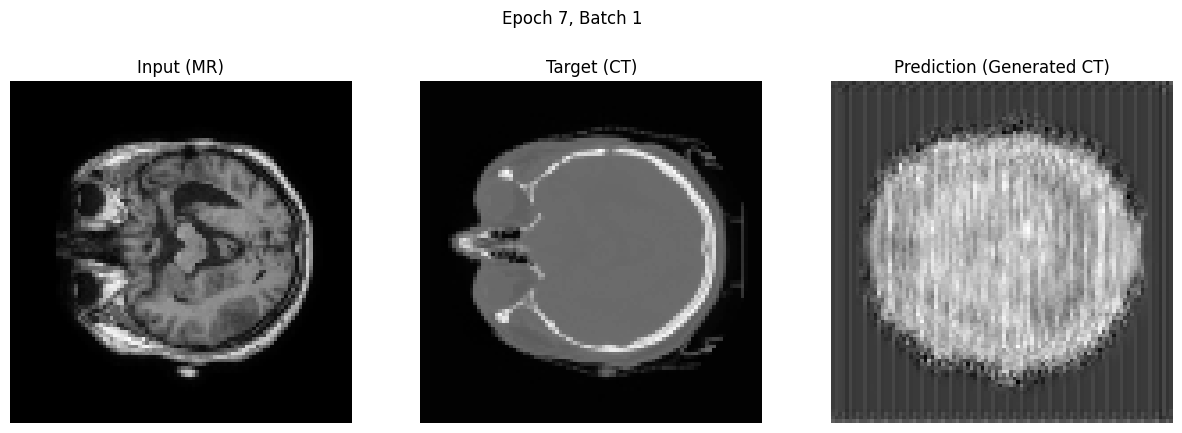

Epoch 8/50, Avg Train Loss: 0.3160146077473958


Epoch 9/50: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it, loss=0.3]


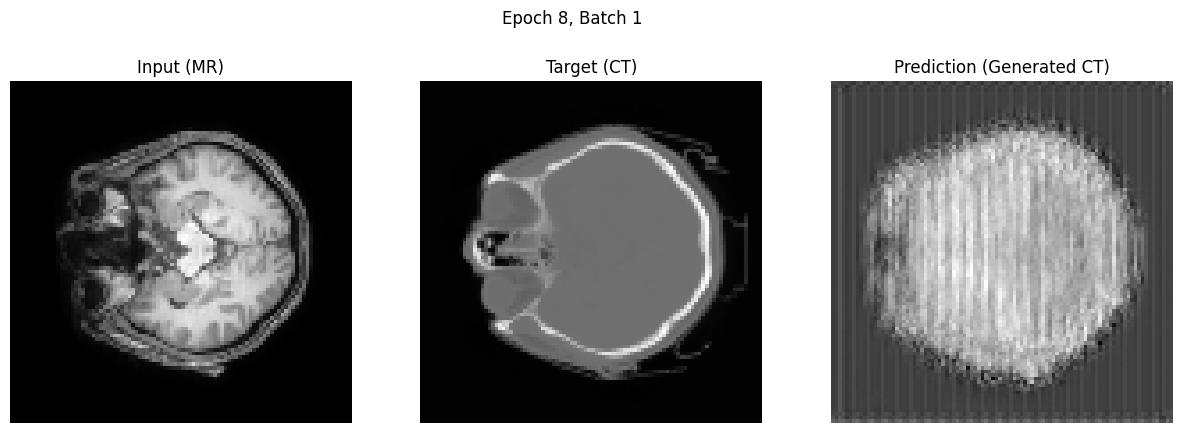

Epoch 9/50, Avg Train Loss: 0.30620937546094257


Epoch 10/50: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it, loss=0.288]


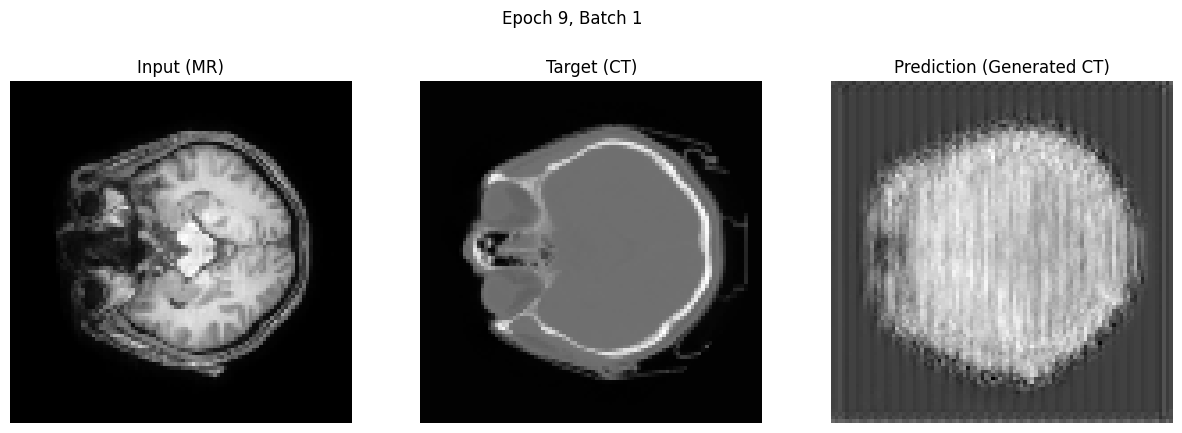

Epoch 10/50, Avg Train Loss: 0.2937042911847432


Epoch 11/50: 100%|██████████| 3/3 [00:07<00:00,  2.41s/it, loss=0.275]


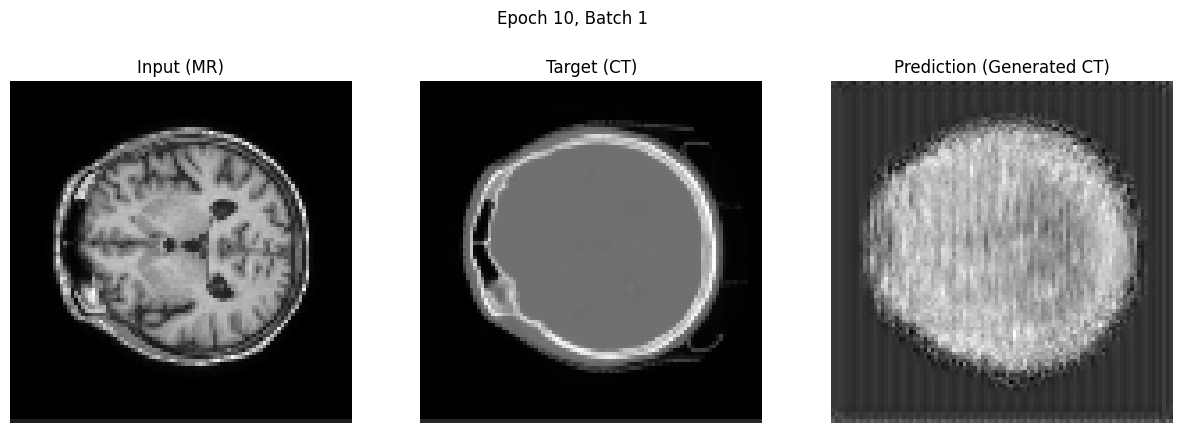

Epoch 11/50, Avg Train Loss: 0.28632790843645733


Epoch 12/50: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it, loss=0.274]


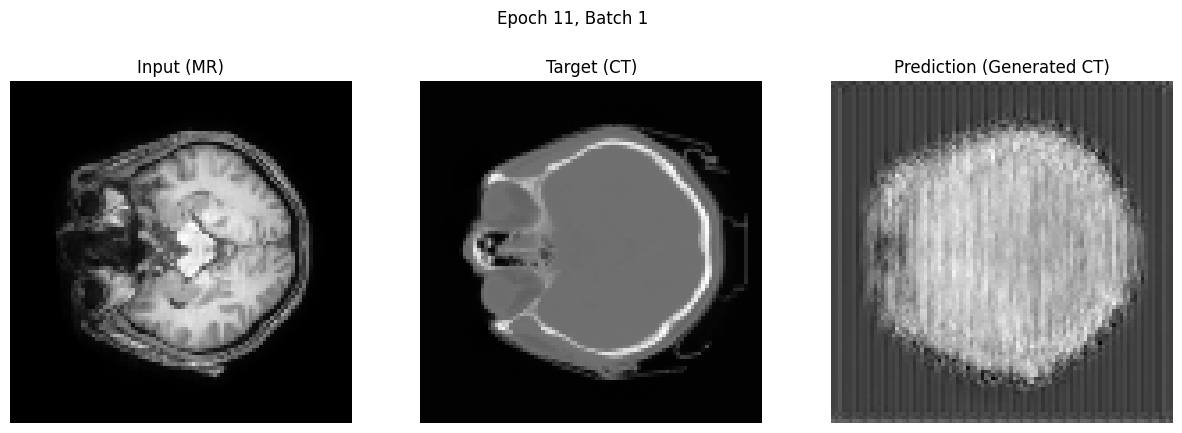

Epoch 12/50, Avg Train Loss: 0.28007765611012775


Epoch 13/50: 100%|██████████| 3/3 [00:07<00:00,  2.34s/it, loss=0.265]


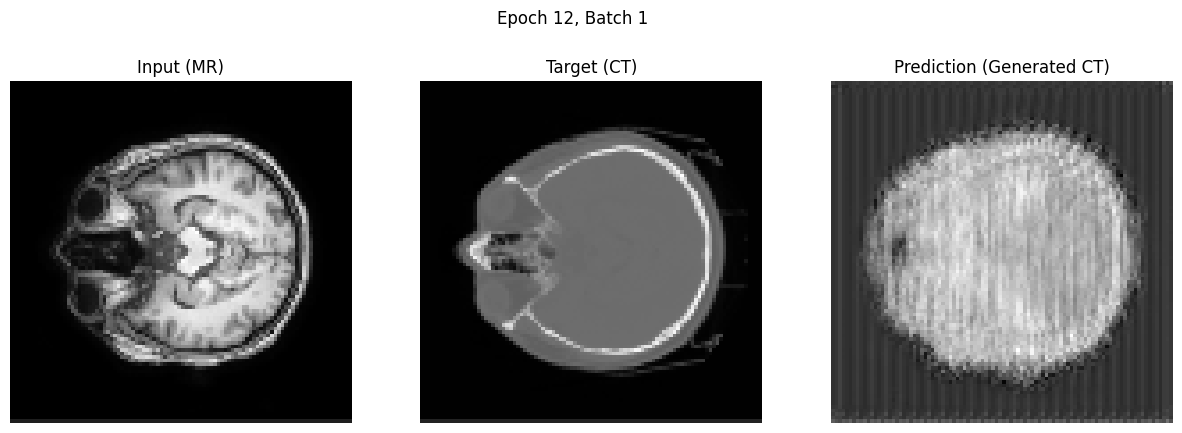

Epoch 13/50, Avg Train Loss: 0.27374515930811566


Epoch 14/50: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it, loss=0.27]


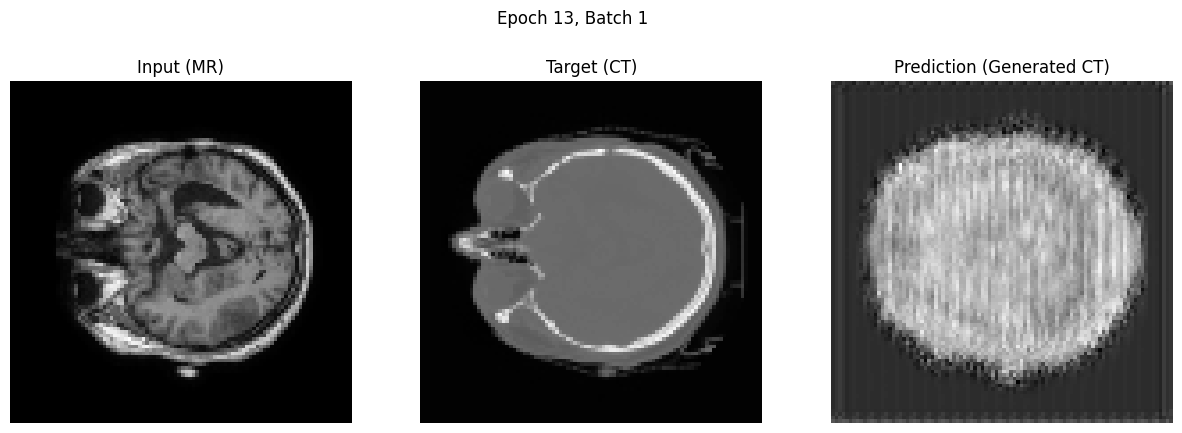

Epoch 14/50, Avg Train Loss: 0.26985223094622296


Epoch 15/50: 100%|██████████| 3/3 [00:07<00:00,  2.41s/it, loss=0.255]


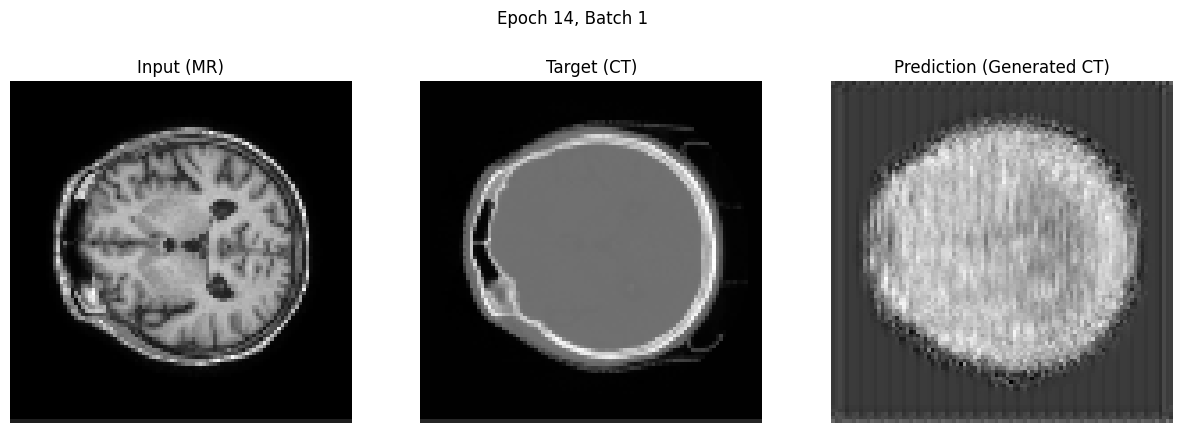

Epoch 15/50, Avg Train Loss: 0.2632540464401245


Epoch 16/50: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it, loss=0.249]


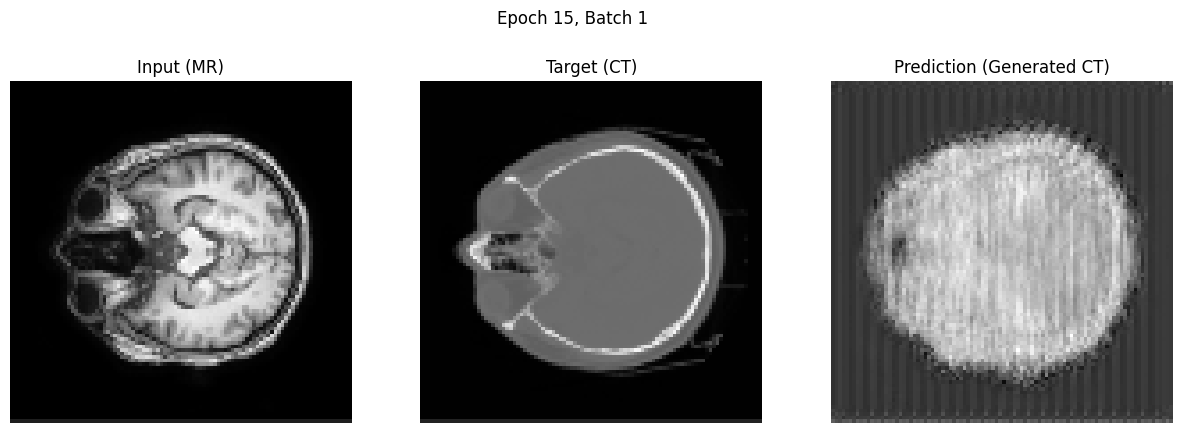

Epoch 16/50, Avg Train Loss: 0.25755009055137634


Epoch 17/50: 100%|██████████| 3/3 [00:07<00:00,  2.48s/it, loss=0.275]


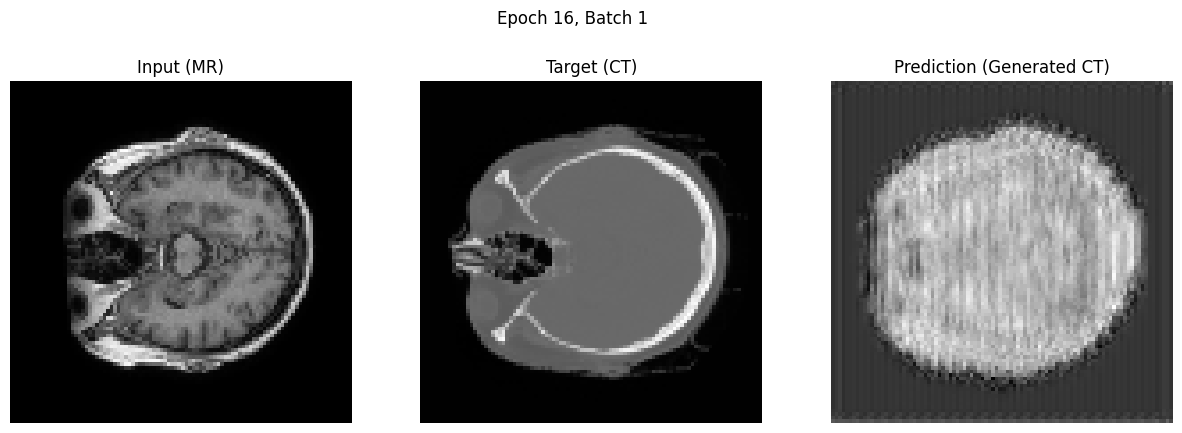

Epoch 17/50, Avg Train Loss: 0.25795703132947284


Epoch 18/50: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it, loss=0.245]


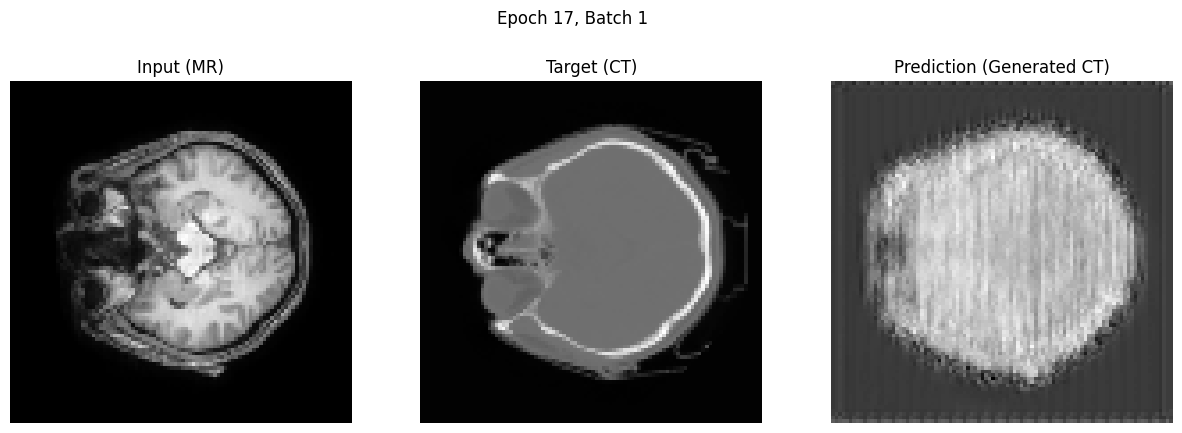

Epoch 18/50, Avg Train Loss: 0.2526162217060725


Epoch 19/50: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it, loss=0.27]


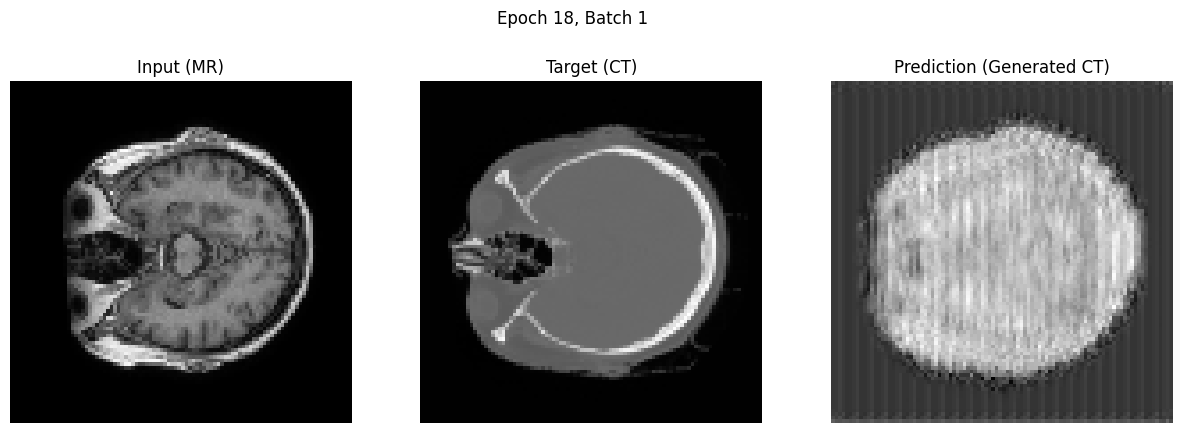

Epoch 19/50, Avg Train Loss: 0.2549813538789749


Epoch 20/50: 100%|██████████| 3/3 [00:07<00:00,  2.36s/it, loss=0.273]


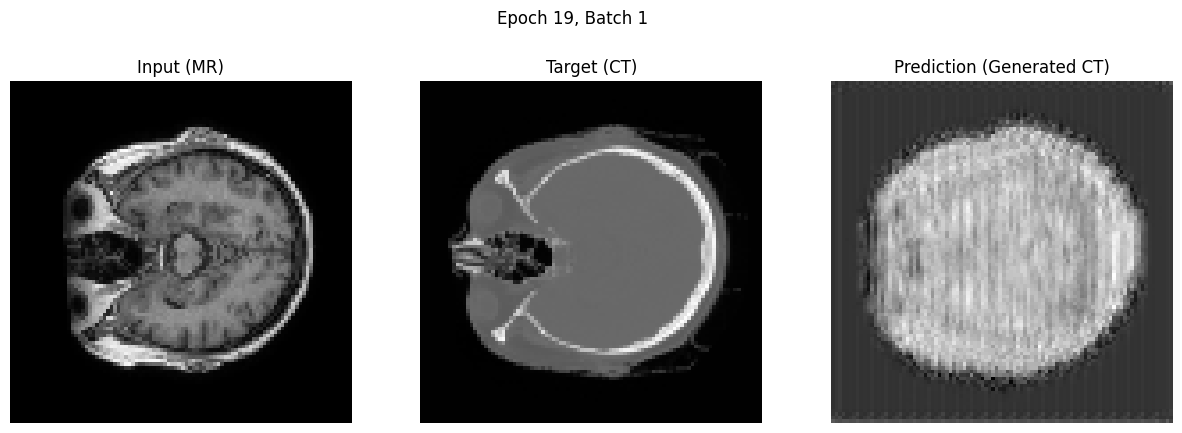

Epoch 20/50, Avg Train Loss: 0.25394334892431897


Epoch 21/50: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it, loss=0.252]


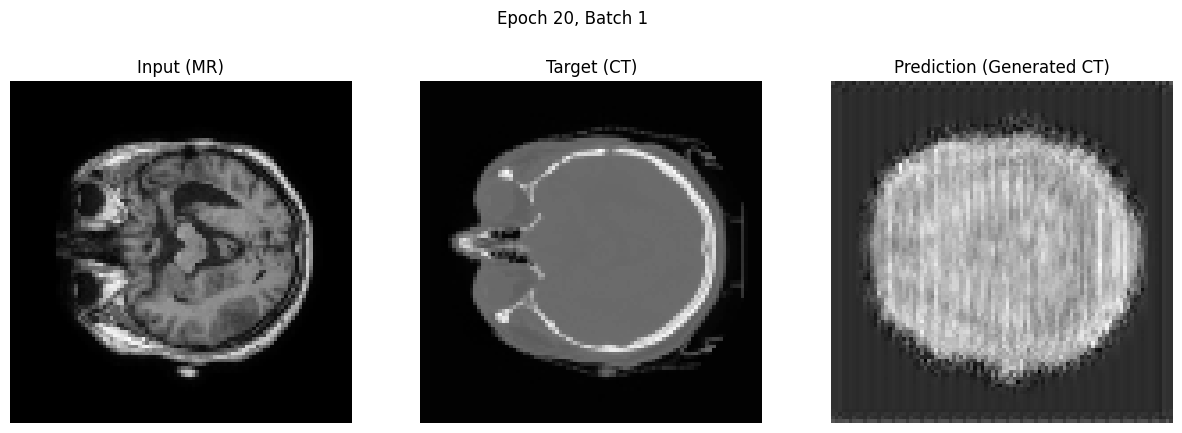

Epoch 21/50, Avg Train Loss: 0.2492970327536265


Epoch 22/50: 100%|██████████| 3/3 [00:07<00:00,  2.43s/it, loss=0.23]


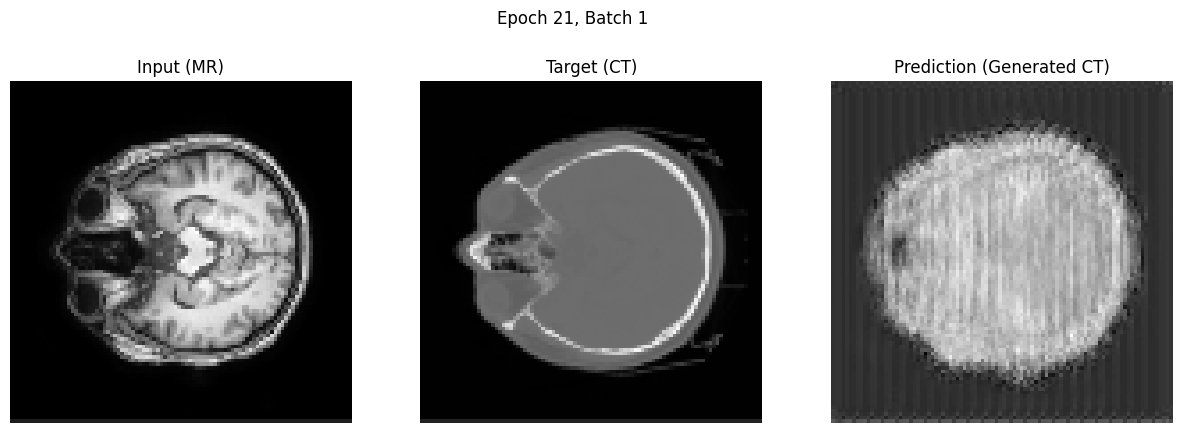

Epoch 22/50, Avg Train Loss: 0.24209730327129364


Epoch 23/50: 100%|██████████| 3/3 [00:07<00:00,  2.40s/it, loss=0.233]


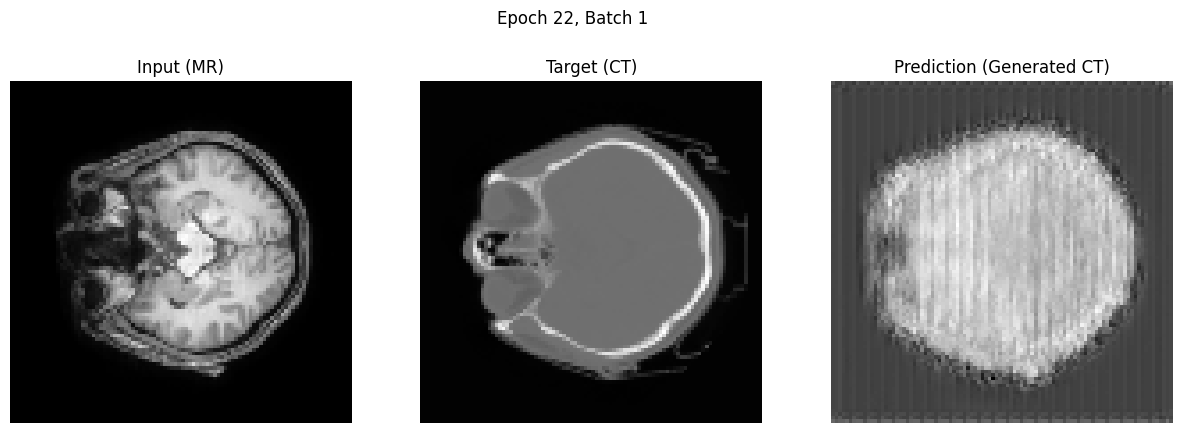

Epoch 23/50, Avg Train Loss: 0.23772177596886954


Epoch 24/50: 100%|██████████| 3/3 [00:07<00:00,  2.43s/it, loss=0.253]


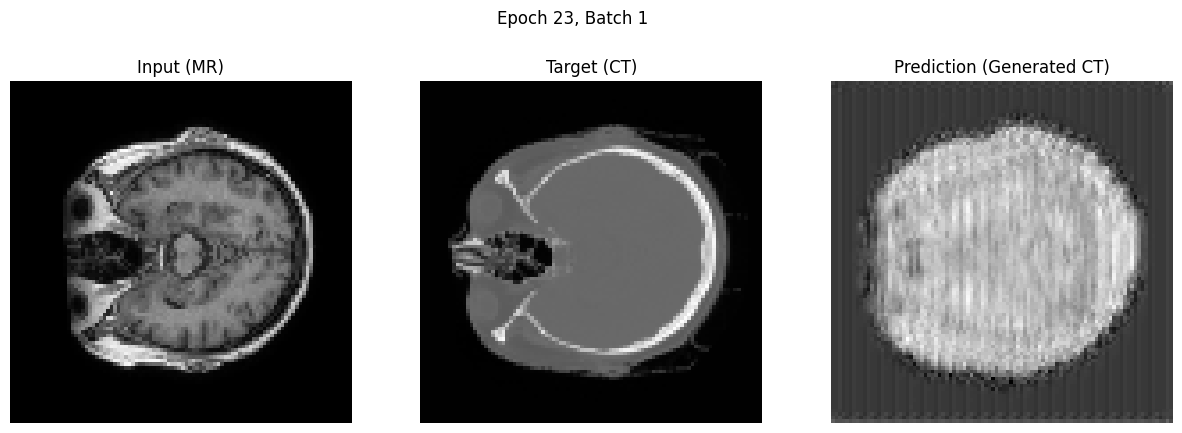

Epoch 24/50, Avg Train Loss: 0.23797805607318878


Epoch 25/50: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it, loss=0.252]


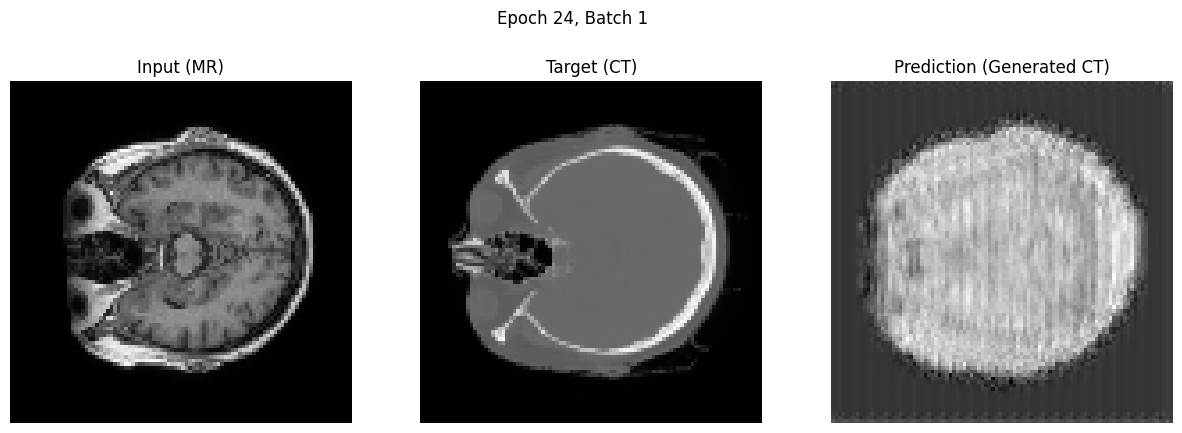

Epoch 25/50, Avg Train Loss: 0.24029817680517832


Epoch 26/50: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it, loss=0.256]


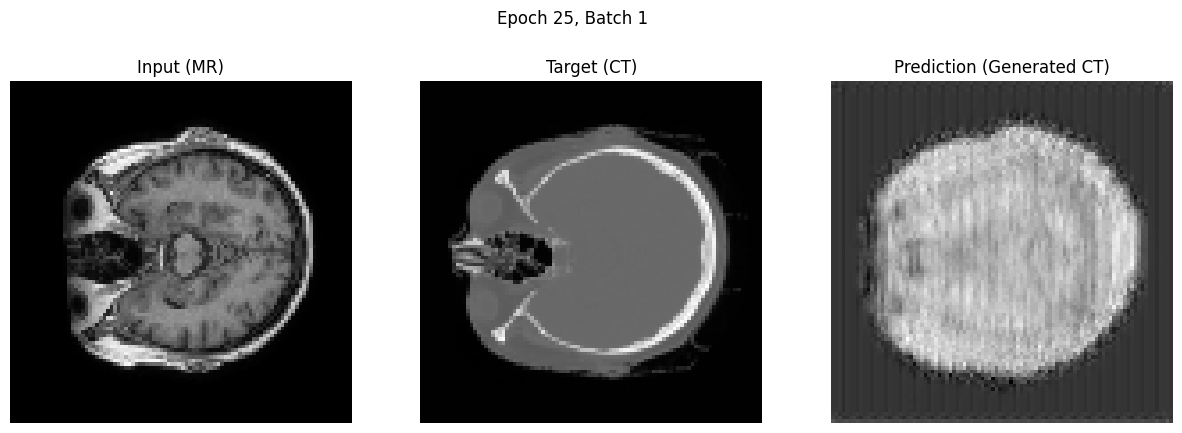

Epoch 26/50, Avg Train Loss: 0.23918523887793222


Epoch 27/50: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it, loss=0.219]


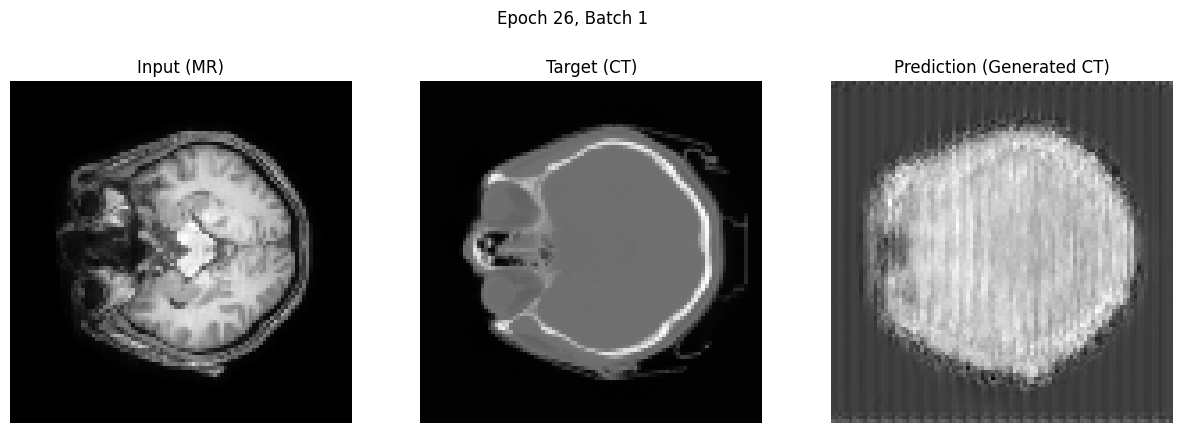

Epoch 27/50, Avg Train Loss: 0.2273342808087667


Epoch 28/50: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it, loss=0.243]


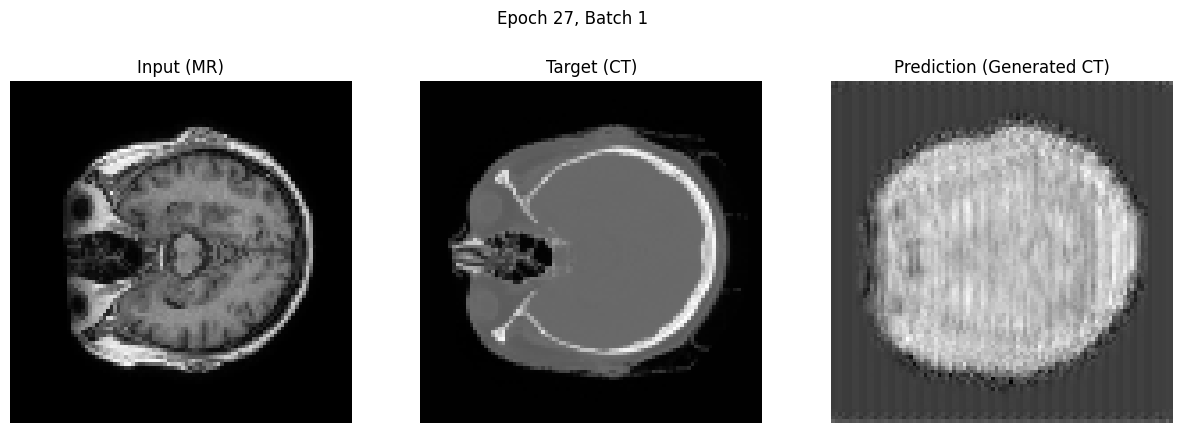

Epoch 28/50, Avg Train Loss: 0.23129886388778687


Epoch 29/50: 100%|██████████| 3/3 [00:07<00:00,  2.44s/it, loss=0.221]


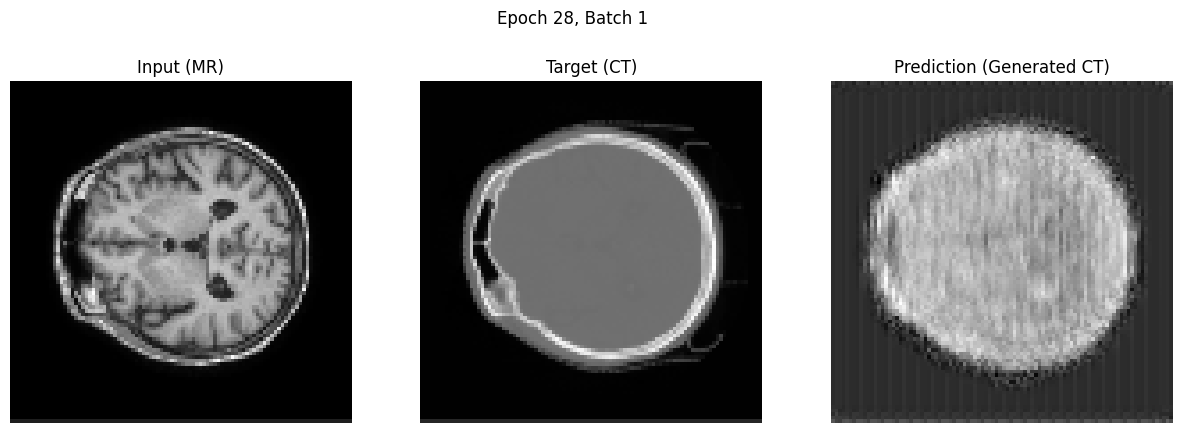

Epoch 29/50, Avg Train Loss: 0.22736612955729166


Epoch 30/50: 100%|██████████| 3/3 [00:07<00:00,  2.52s/it, loss=0.219]


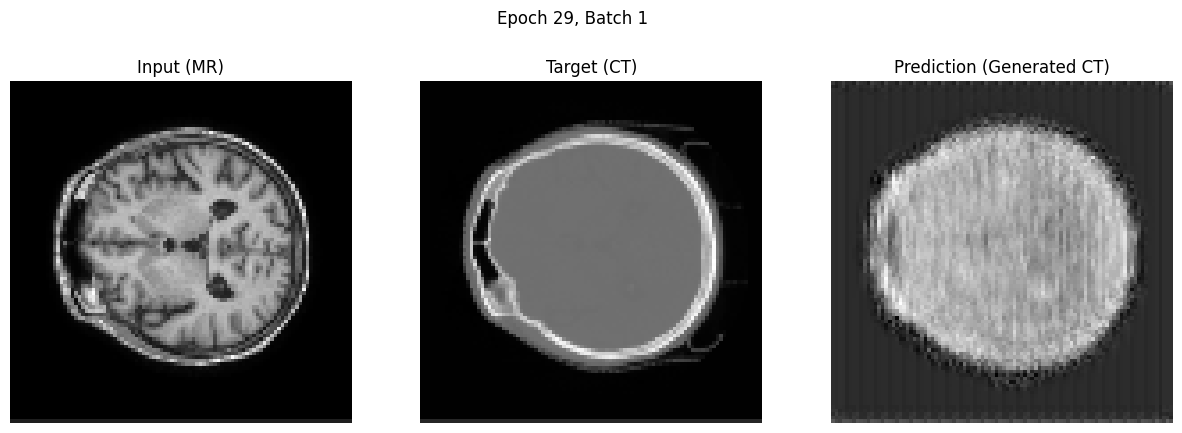

Epoch 30/50, Avg Train Loss: 0.22413974006970724


Epoch 31/50: 100%|██████████| 3/3 [00:07<00:00,  2.62s/it, loss=0.215]


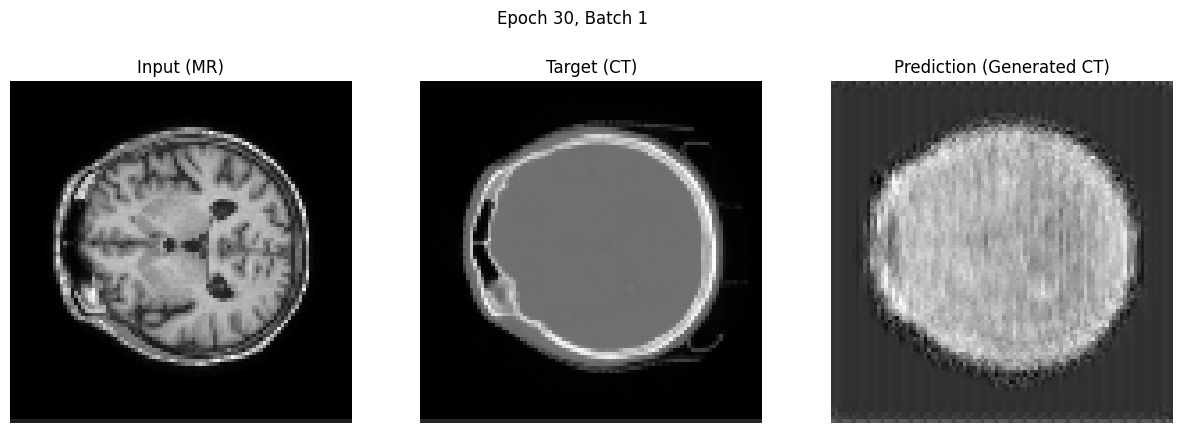

Epoch 31/50, Avg Train Loss: 0.22387681404749551


Epoch 32/50: 100%|██████████| 3/3 [00:07<00:00,  2.44s/it, loss=0.21]


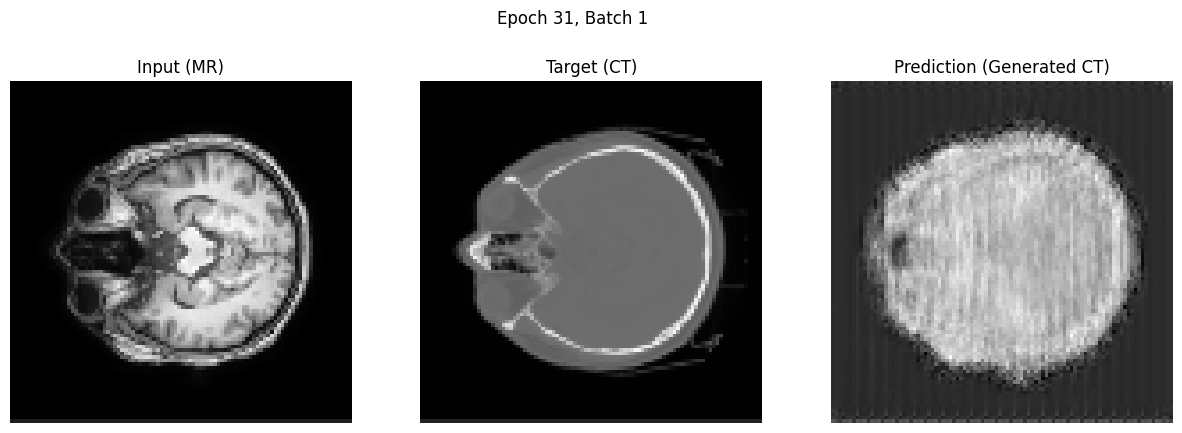

Epoch 32/50, Avg Train Loss: 0.21632442871729532


Epoch 33/50: 100%|██████████| 3/3 [00:08<00:00,  2.99s/it, loss=0.211]


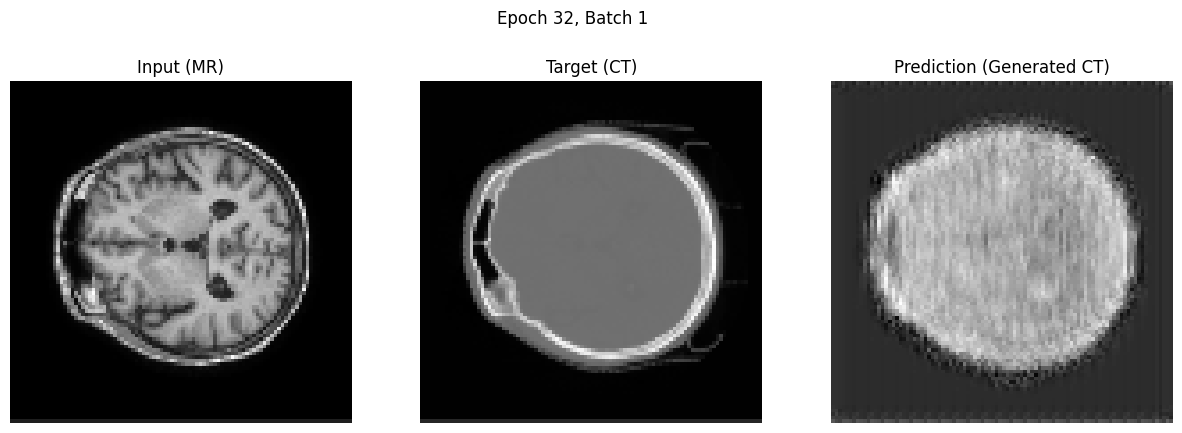

Epoch 33/50, Avg Train Loss: 0.21643158296744028


Epoch 34/50: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it, loss=0.234]


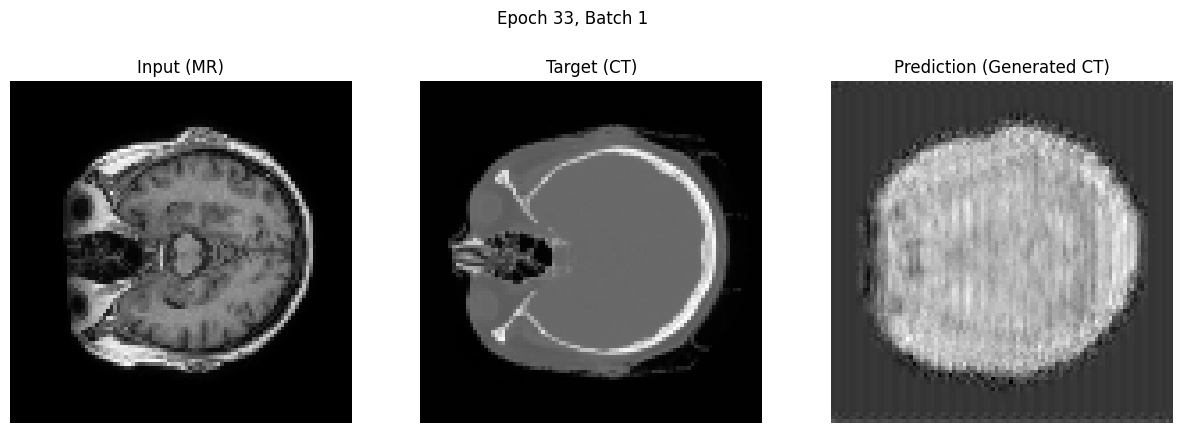

Epoch 34/50, Avg Train Loss: 0.21945006648699442


Epoch 35/50: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it, loss=0.209]


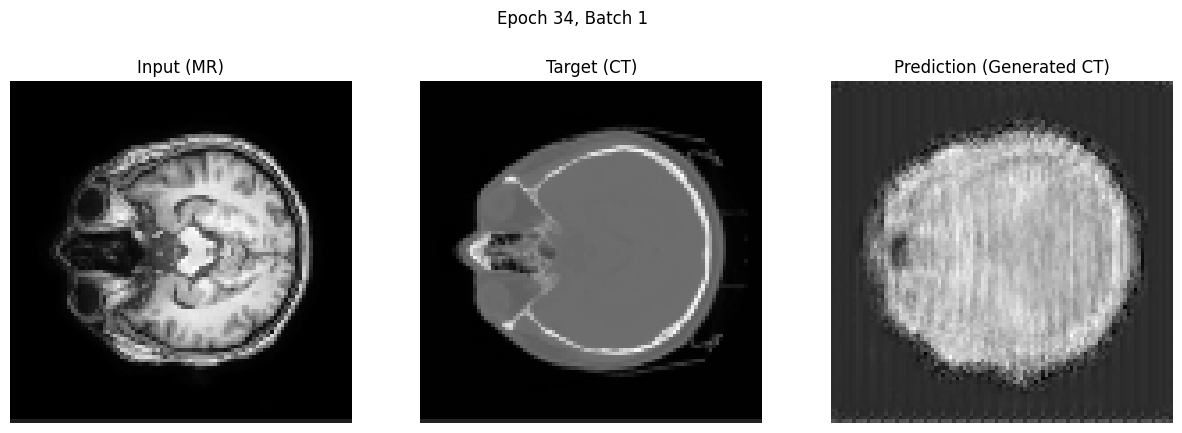

Epoch 35/50, Avg Train Loss: 0.213803102572759


Epoch 36/50: 100%|██████████| 3/3 [00:07<00:00,  2.45s/it, loss=0.22]


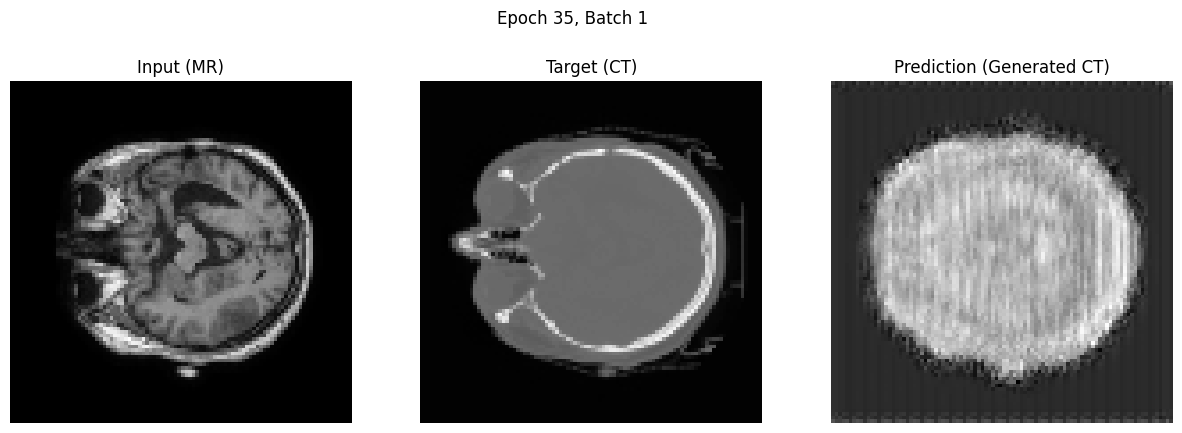

Epoch 36/50, Avg Train Loss: 0.21534115572770438


Epoch 37/50: 100%|██████████| 3/3 [00:07<00:00,  2.40s/it, loss=0.229]


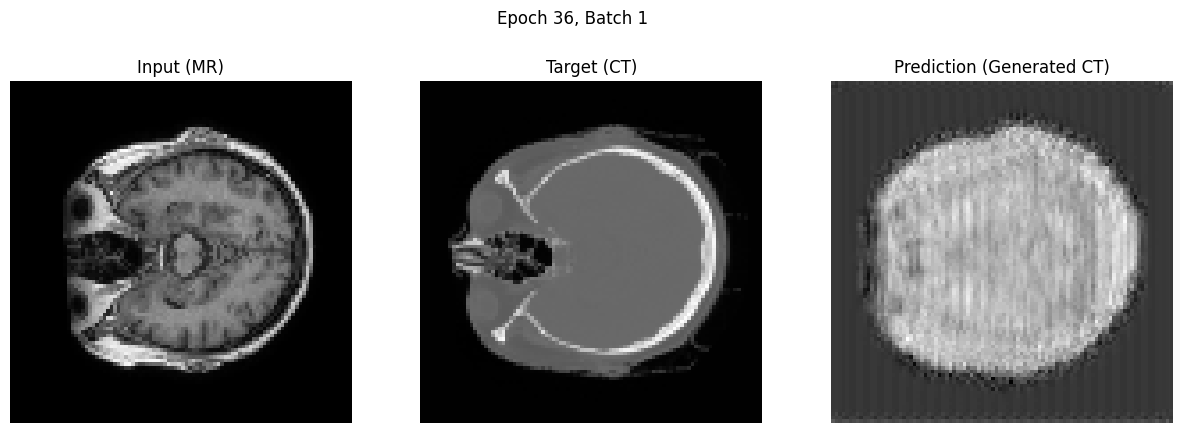

Epoch 37/50, Avg Train Loss: 0.21603742241859436


Epoch 38/50: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it, loss=0.216]


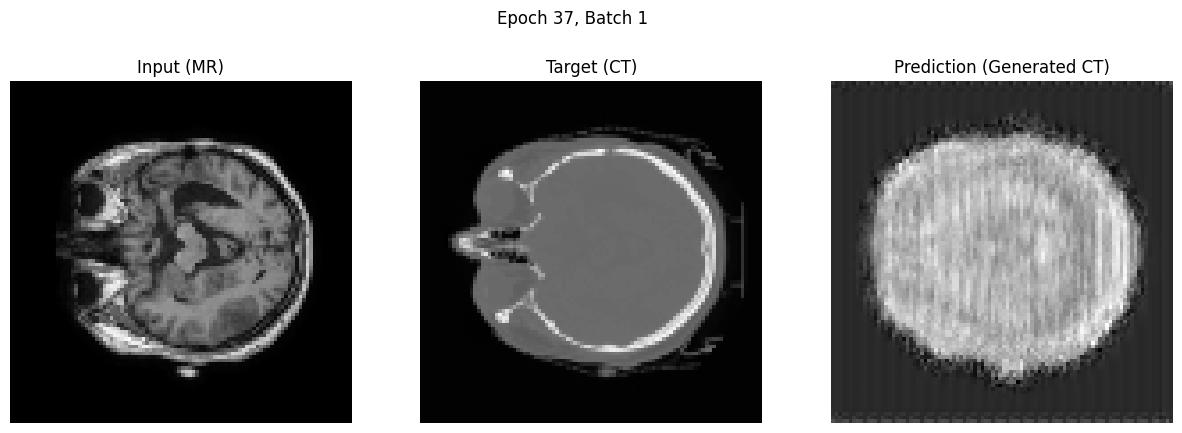

Epoch 38/50, Avg Train Loss: 0.21271773676077524


Epoch 39/50: 100%|██████████| 3/3 [00:07<00:00,  2.45s/it, loss=0.216]


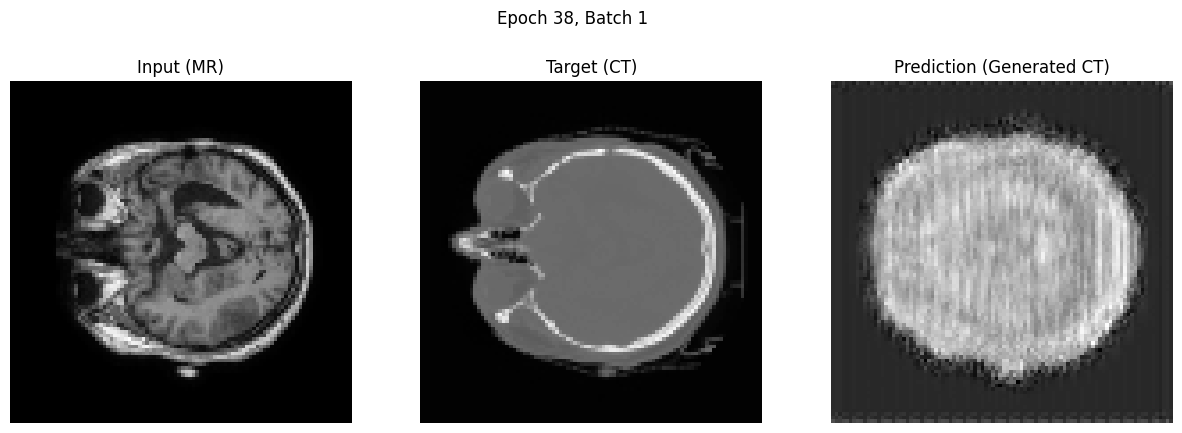

Epoch 39/50, Avg Train Loss: 0.21219490468502045


Epoch 40/50: 100%|██████████| 3/3 [00:09<00:00,  3.09s/it, loss=0.226]


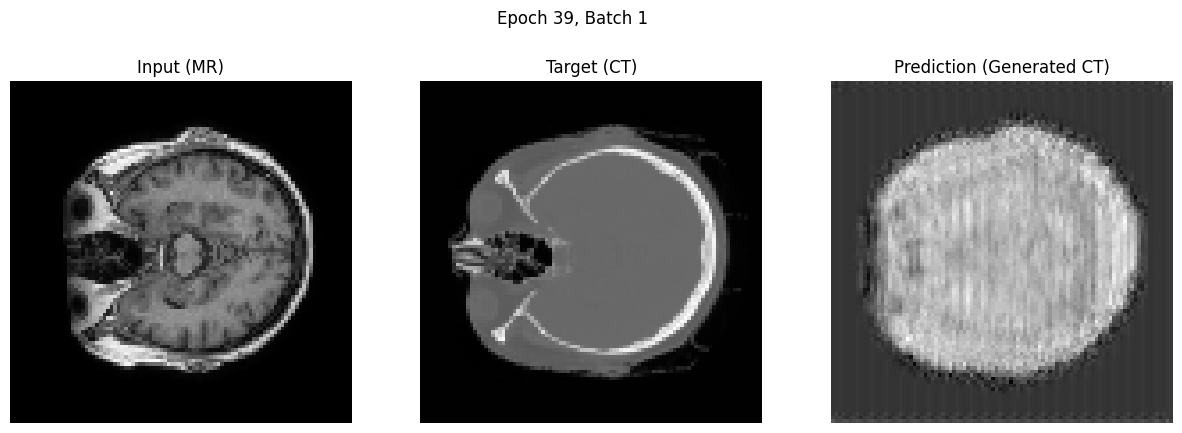

Epoch 40/50, Avg Train Loss: 0.21341837445894876


Epoch 41/50: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it, loss=0.225]


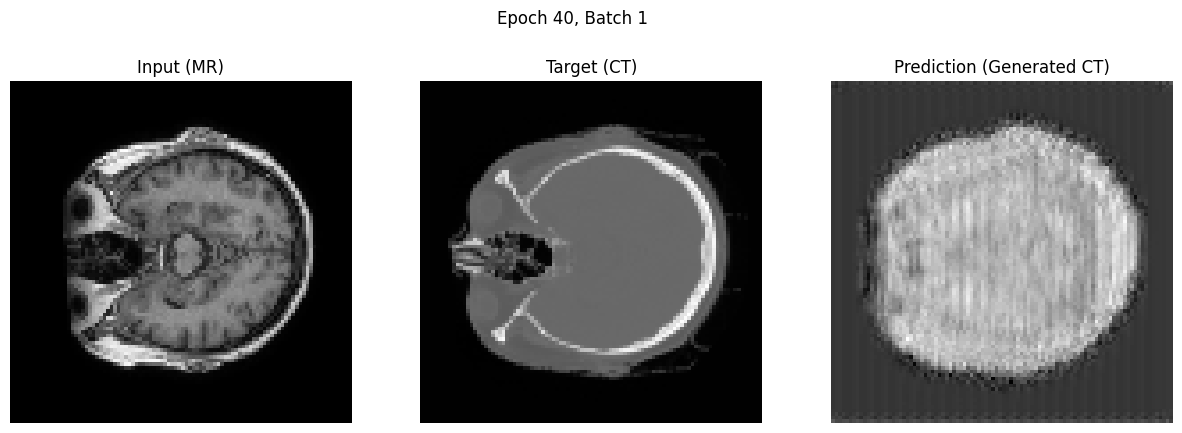

Epoch 41/50, Avg Train Loss: 0.2127217948436737


Epoch 42/50: 100%|██████████| 3/3 [00:07<00:00,  2.38s/it, loss=0.204]


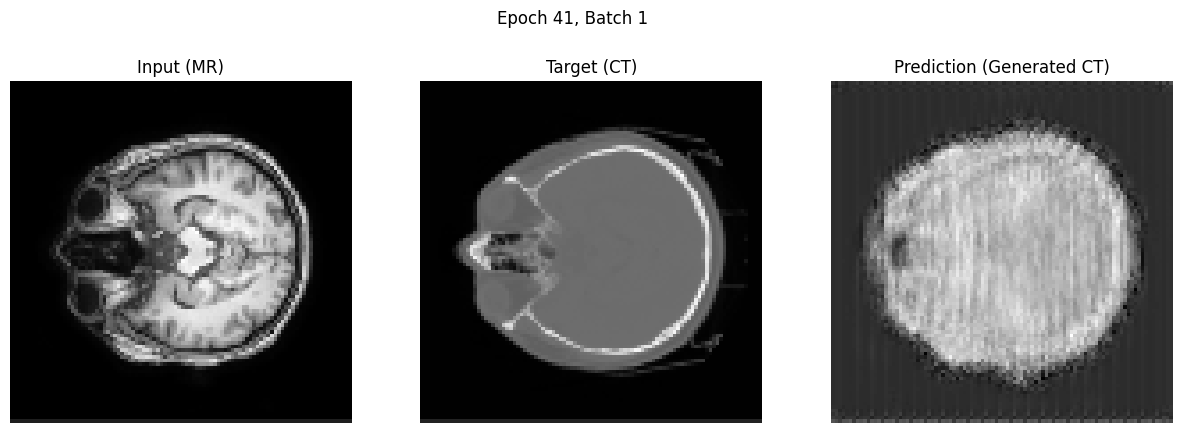

Epoch 42/50, Avg Train Loss: 0.20912428696950278


Epoch 43/50: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it, loss=0.224]


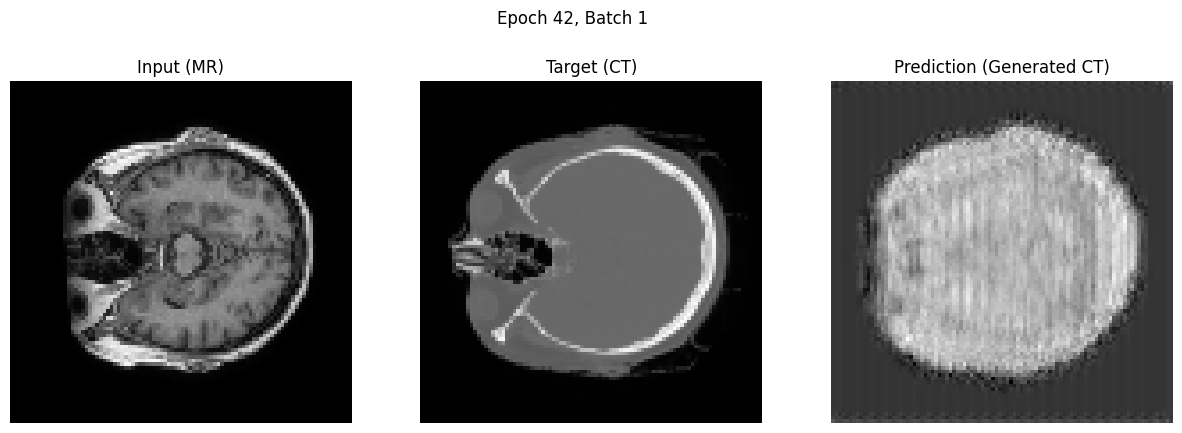

Epoch 43/50, Avg Train Loss: 0.21209906538327536


Epoch 44/50: 100%|██████████| 3/3 [00:07<00:00,  2.44s/it, loss=0.203]


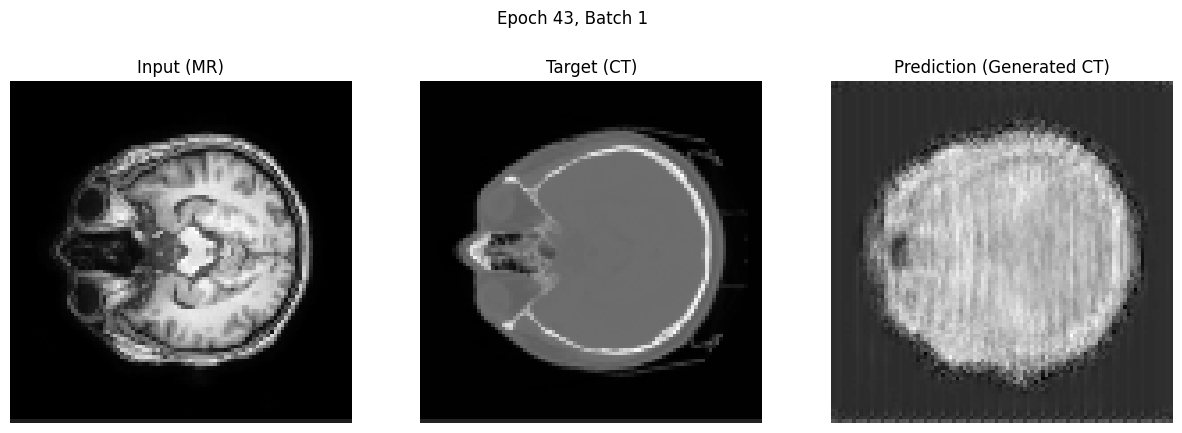

Epoch 44/50, Avg Train Loss: 0.20839877923329672


Epoch 45/50: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it, loss=0.224]


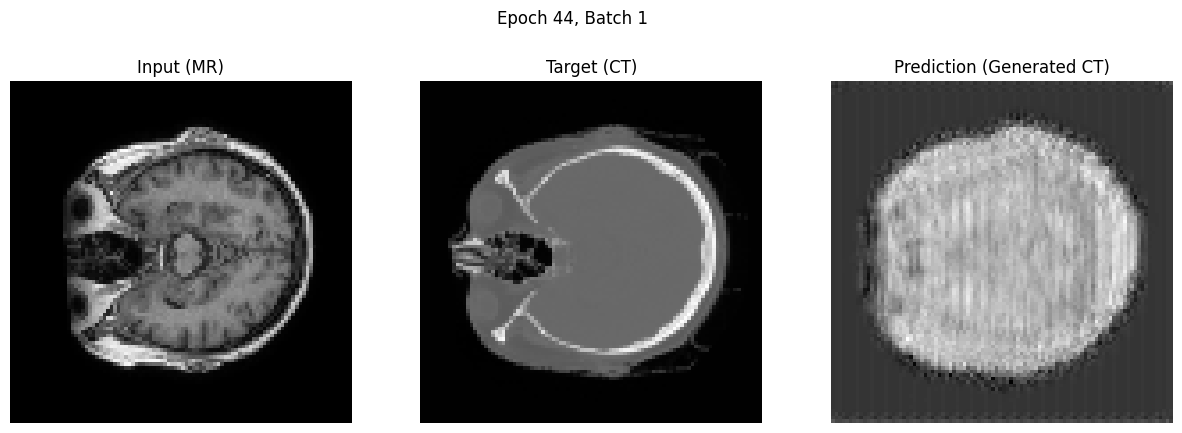

Epoch 45/50, Avg Train Loss: 0.21157102286815643


Epoch 46/50: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it, loss=0.213]


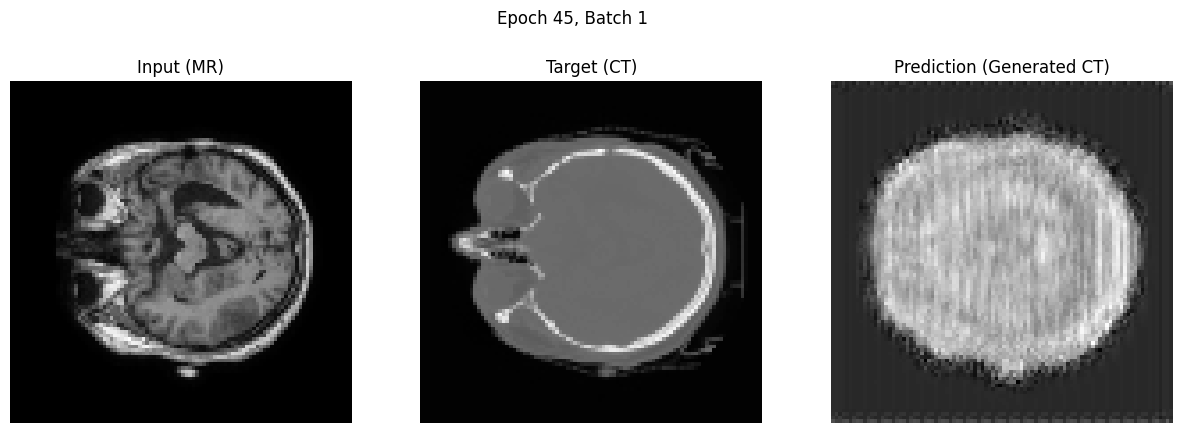

Epoch 46/50, Avg Train Loss: 0.20955033600330353


Epoch 47/50: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, loss=0.203]


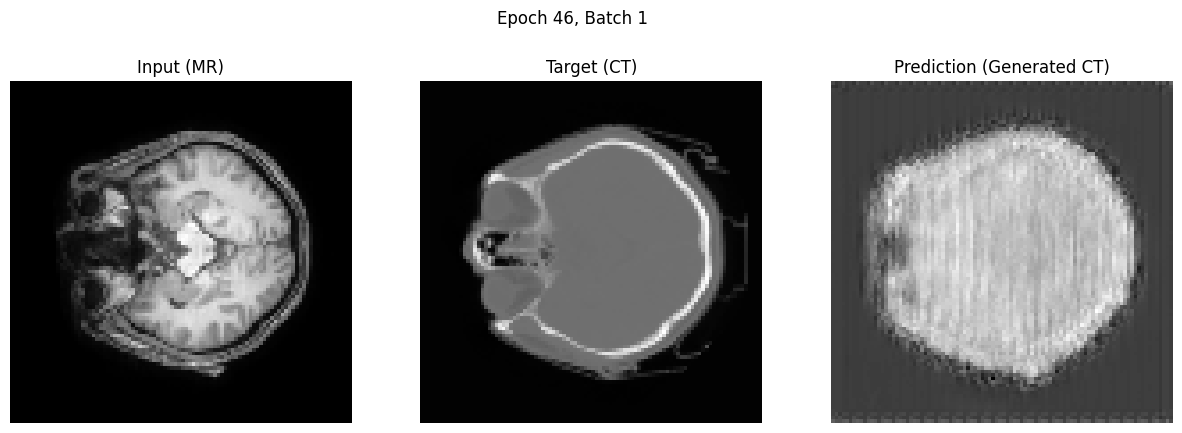

Epoch 47/50, Avg Train Loss: 0.2074494113524755


Epoch 48/50: 100%|██████████| 3/3 [00:07<00:00,  2.45s/it, loss=0.202]


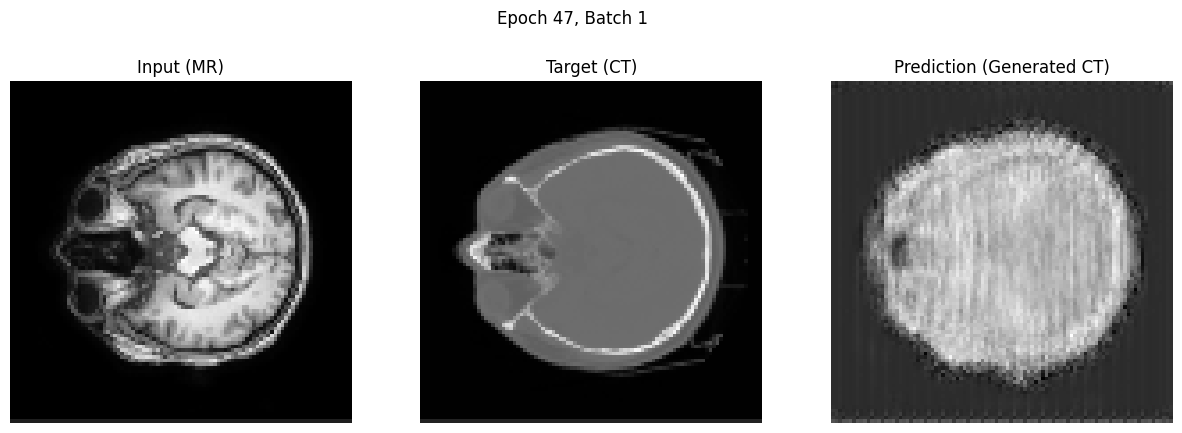

Epoch 48/50, Avg Train Loss: 0.20718949536482492


Epoch 49/50: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it, loss=0.222]


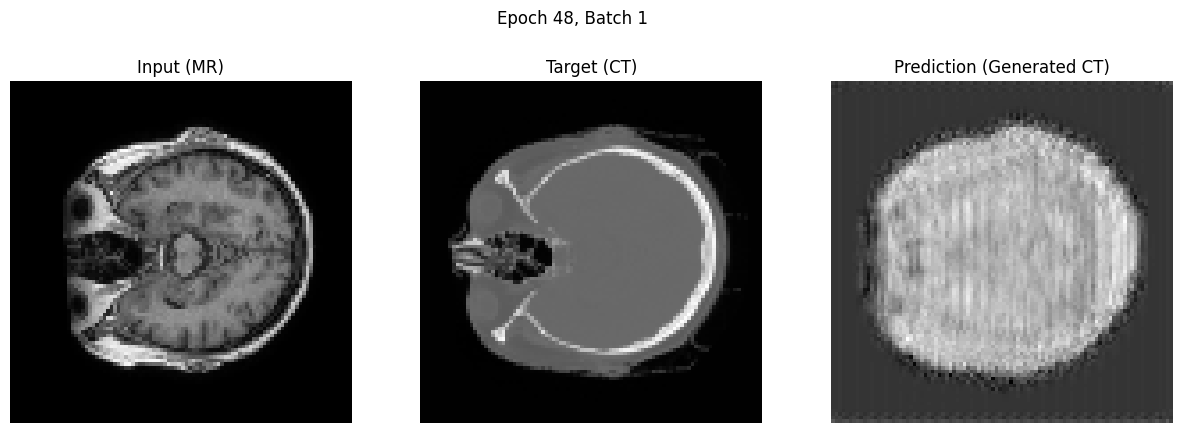

Epoch 49/50, Avg Train Loss: 0.21037847300370535


Epoch 50/50: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it, loss=0.202]


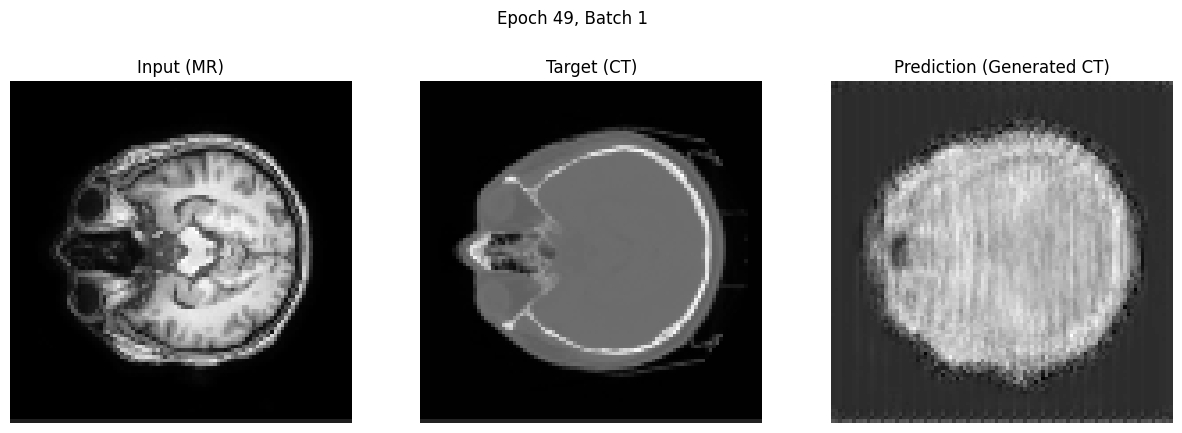

Epoch 50/50, Avg Train Loss: 0.20684342086315155


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import argparse
import matplotlib.pyplot as plt

def visualize_results(input_image, target_image, predicted_image, epoch, idx):
    """
    視覺化輸入影像、目標影像與預測影像
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 輸入影像
    axes[0].imshow(input_image[0, 0, :, :, input_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Input (MR)")
    axes[0].axis("off")

    # 目標影像3
    axes[1].imshow(target_image[0, 0, :, :, target_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("Target (CT)")
    axes[1].axis("off")

    # 預測影像
    axes[2].imshow(predicted_image[0, 0, :, :, predicted_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("Prediction (Generated CT)")
    axes[2].axis("off")

    plt.suptitle(f"Epoch {epoch}, Batch {idx}")
    plt.show()

# 設置訓練設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 優化器與損失函數
optimizer = optim.Adam(model.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # 學習率調整
criterion = nn.L1Loss()

# 訓練參數
epochs = 50
best_loss = float("inf")

data_path = "/content/small"

train_dataset = MRCTDataset(data_path)
# test_dataset = SegmentationDataset(root=(data_path+'/Test'), low_res=128, transform_img=transform_img, transform_mask=transform_mask)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
# val_loader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=2)

for mr, ct in train_loader:
    print(f"MR shape: {mr.shape}, CT shape: {ct.shape}")
    break

for epoch in range(epochs):
    # 訓練階段
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for mr, ct in progress_bar:
        mr, ct = mr.to(device), ct.to(device)




        optimizer.zero_grad()
        output = model(mr)
        loss = criterion(output, ct)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    visualize_results(mr, ct, output, epoch, 1)

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Train Loss: {avg_train_loss}")

    # 驗證階段
    model.eval()
    val_loss = 0.0
    # with torch.no_grad():
    #     for mr, ct in val_loader:
    #         mr, ct = mr.to(device), ct.to(device)
    #         output = model(mr)
    #         loss = criterion(output, ct)
    #         val_loss += loss.item()

    # avg_val_loss = val_loss / len(val_loader)
    # print(f"Epoch {epoch+1}/{epochs}, Avg Validation Loss: {avg_val_loss}")

    # 保存最佳模型
    # if avg_val_loss < best_loss:
    #     best_loss = avg_val_loss
    #     torch.save(model.state_dict(), "best_model.pth")
    #     print("Best model saved!")

    scheduler.step()


Test

In [ ]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for mr, ct in test_loader:
            mr = mr.to(device)
            output = model(mr)
            # 後處理（例如將預測結果儲存為 .nii.gz）
            output = output.cpu().numpy()
            # Save output here...

test_loader = DataLoader(MRCTDataset(data_dir="Task1/pelvis"), batch_size=1, shuffle=False)
test_model(model, test_loader)
